In [1]:
import random
import math
import probros as pr

In [2]:
random.seed(0)

We use the `@pr.trace` decorator to construct a probabilistic program from a python function.

## BRP model

In [3]:
@pr.trace
def brp(toSend, maxFailed):
    sent = 0
    failed = 0
    totalFailed = 0

    i = 1
    while failed < maxFailed and sent < toSend:
        b = pr.sample(f"attempt_transmit_{i}", pr.Bernoulli(0.1))
        if b:
            failed = 0
            sent = sent + 1
        else:
            failed = failed + 1
            totalFailed = totalFailed + 1
        i += 1

    return totalFailed

In [4]:
brp(5, 3) # trace has variable number of random value draws

(3,
 -0.31608154697347884,
 Trace(input=((5, 3), {}))
 0.: {'address': 'attempt_transmit_1', 'kind': 'sample', 'value': False, 'logprob': -0.10536051565782628, 'distribution': Bernoulli(0.1)}
 1.: {'address': 'attempt_transmit_2', 'kind': 'sample', 'value': False, 'logprob': -0.10536051565782628, 'distribution': Bernoulli(0.1)}
 2.: {'address': 'attempt_transmit_3', 'kind': 'sample', 'value': False, 'logprob': -0.10536051565782628, 'distribution': Bernoulli(0.1)}
 retval=3logprob: -0.31608154697347884)

In [5]:
@pr.trace
def brp(toSend, maxFailed):
    sent = 0
    failed = 0
    totalFailed = 0

    while failed < maxFailed and sent < toSend:
        b = pr.sample(f"attempt_transmit", pr.Bernoulli(0.1))
        if b:
            failed = 0
            sent = sent + 1
        else:
            failed = failed + 1
            totalFailed = totalFailed + 1

    return totalFailed

In [6]:
brp(5, 3) # now addresses need not be unique

(3,
 -0.31608154697347884,
 Trace(input=((5, 3), {}))
 0.: {'address': 'attempt_transmit', 'kind': 'sample', 'value': False, 'logprob': -0.10536051565782628, 'distribution': Bernoulli(0.1)}
 1.: {'address': 'attempt_transmit', 'kind': 'sample', 'value': False, 'logprob': -0.10536051565782628, 'distribution': Bernoulli(0.1)}
 2.: {'address': 'attempt_transmit', 'kind': 'sample', 'value': False, 'logprob': -0.10536051565782628, 'distribution': Bernoulli(0.1)}
 retval=3logprob: -0.31608154697347884)

## Coin flip model

We want to infer if a coin is biased.

What is the true probability of flipping the heads (== 1).

We have observed following flips 0,0,1,1,1.

In [7]:
@pr.trace
def coin_flips(data):
    p = pr.sample("p", pr.Uniform(0, 1))
    for i in range(len(data)):
        pr.observe(data[i], f"flip_{i}", pr.Bernoulli(p))
    return p

In [8]:
data = [0,0,1,1,1]
coin_flips(data)

(0.7837985890347726,
 -3.7938992753233527,
 Trace(input=(([0, 0, 1, 1, 1],), {}))
 0.: {'address': 'p', 'kind': 'sample', 'value': 0.7837985890347726, 'logprob': -0.0, 'distribution': Uniform(0, 1)}
 1.: {'address': 'flip_0', 'kind': 'observe', 'value': 0, 'logprob': -1.531544847594683, 'distribution': Bernoulli(0.7837985890347726)}
 2.: {'address': 'flip_1', 'kind': 'observe', 'value': 0, 'logprob': -1.531544847594683, 'distribution': Bernoulli(0.7837985890347726)}
 3.: {'address': 'flip_2', 'kind': 'observe', 'value': 1, 'logprob': -0.24360319337799582, 'distribution': Bernoulli(0.7837985890347726)}
 4.: {'address': 'flip_3', 'kind': 'observe', 'value': 1, 'logprob': -0.24360319337799582, 'distribution': Bernoulli(0.7837985890347726)}
 5.: {'address': 'flip_4', 'kind': 'observe', 'value': 1, 'logprob': -0.24360319337799582, 'distribution': Bernoulli(0.7837985890347726)}
 retval=0.7837985890347726logprob: -3.7938992753233527)

Running the model corresponds to:
- `sample` a value for `p`,
- add to log probability `logprob += logpdf(Uniform(0,1), p)`
- `observe` each data point `data[i]`
- add to the log probability `logprob += logpdf(Bernoulli(p), data[i])` (depends on `p`)
- return `p`, `logprob`, and trace


`logprob = logpdf(Uniform(0,1), p) + logpdf(Bernoulli(p), data[0]) + logpdf(Bernoulli(p), data[1]) + logpdf(Bernoulli(p), data[2]) + logpdf(Bernoulli(p), data[3]) + logpdf(Bernoulli(p), data[4])`

Thus,

`exp(logprob) = Prob(p,flip_0=0,flip_1=0,flip_2=1,flip_3=1,flip_4=1) = Prob(p, Y=data)`

The posterior is proportional to the joint:

`Prob(p|Y=data) = Prob(p, Y=data) / Prob(Y=data)`

In [9]:
# same model but explicitly vectorised
@pr.trace
def coin_flips(data):
    p = pr.sample("p", pr.Uniform(0, 1))
    pr.observe(data, "flip", pr.IID(pr.Bernoulli(p), len(data)))
    return p
coin_flips(data)

(0.30331272607892745,
 -4.301810006027625,
 Trace(input=(([0, 0, 1, 1, 1],), {}))
 0.: {'address': 'p', 'kind': 'sample', 'value': 0.30331272607892745, 'logprob': -0.0, 'distribution': Uniform(0, 1)}
 1.: {'address': 'flip', 'kind': 'observe', 'value': [0, 0, 1, 1, 1], 'logprob': -4.301810006027625, 'distribution': IID(Bernoulli(0.30331272607892745), 5)}
 retval=0.30331272607892745logprob: -4.301810006027625)

In [10]:
# same model but implicitly vectorised
@pr.trace
def coin_flips(data):
    p = pr.sample("p", pr.Uniform(0, 1))
    pr.observe(data, "flip", pr.Bernoulli(p))
    return p
coin_flips(data)

(0.4765969541523558,
 -3.5180592544722904,
 Trace(input=(([0, 0, 1, 1, 1],), {}))
 0.: {'address': 'p', 'kind': 'sample', 'value': 0.4765969541523558, 'logprob': -0.0, 'distribution': Uniform(0, 1)}
 1.: {'address': 'flip', 'kind': 'observe', 'value': [0, 0, 1, 1, 1], 'logprob': -3.5180592544722904, 'distribution': Bernoulli(0.4765969541523558)}
 retval=0.4765969541523558logprob: -3.5180592544722904)

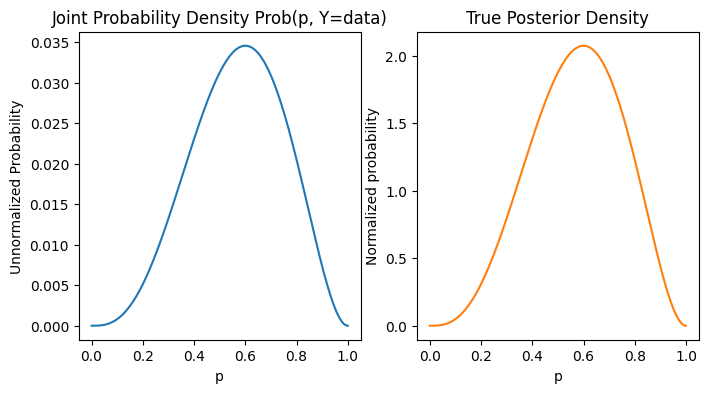

In [11]:
# We can make a few draws, and plot the result
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta 
samples = [coin_flips(data)[:2] for _ in range(1000)]
samples = sorted(samples)

fig, ax = plt.subplots(1, 2, figsize=(8,4))
ps = np.array([s[0] for s in samples])
logprobs = np.array([s[1] for s in samples])
ax[0].plot(ps, np.exp(logprobs))
ax[0].set_xlabel("p")
ax[0].set_ylabel("Unnormalized Probability")
ax[0].set_title("Joint Probability Density Prob(p, Y=data)")
ax[1].plot(ps, beta.pdf(ps, 3+1,2+1), c="tab:orange")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Normalized probability")
ax[1].set_title("True Posterior Density")
plt.show()

In [12]:
# Indeed the area under the curve does not equal 1 -> unnormalized
np.trapz(np.exp(logprobs), ps)

0.016666660618663735

We can also equivalently formulate the model in terms of a factor.

Essentially, observe statements are factors: `factor(distribution.logprob(value)) ~ observe(value, distribution)`.

In [13]:
@pr.trace
def coin_flips_factor(data):
    p = pr.sample("p", pr.Uniform(0, 1))
    f = 0.
    for i in range(len(data)):
        f += math.log(p if data[i] == 1 else 1-p)
    pr.factor(f)
    return p

In [14]:
coin_flips_factor(data)

(0.16985884355967462,
 -5.690681605853097,
 Trace(input=(([0, 0, 1, 1, 1],), {}))
 0.: {'address': 'p', 'kind': 'sample', 'value': 0.16985884355967462, 'logprob': -0.0, 'distribution': Uniform(0, 1)}
 1.: {'address': 'factor:1', 'kind': 'factor', 'logprob': -5.690681605853097}
 retval=0.16985884355967462logprob: -5.690681605853097)

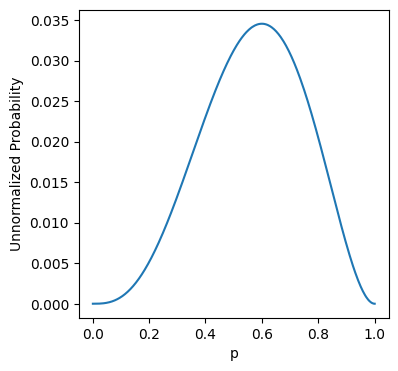

0.01666665161960825

In [15]:
samples = [coin_flips_factor(data)[:2] for _ in range(1000)]
samples = sorted(samples)

fig, ax = plt.subplots(1, 1, figsize=(4,4))
ps = np.array([s[0] for s in samples])
logprobs = np.array([s[1] for s in samples])
ax.plot(ps, np.exp(logprobs))
ax.set_xlabel("p")
ax.set_ylabel("Unnormalized Probability")
plt.show()
np.trapz(np.exp(logprobs), ps)

## Linear Regression Model

In more complicated models, where we have more than 1 latent variable, it is not as simple to compute the normalization constant as above.

Therefore, you need more sophisticated inference algorithms to approximate the posterior.

However, I think this is not the scope of our package.

Simply producing samples by running the model should be enough.

For instance, consider a linear regression model with 3 latents:

In [16]:
@pr.trace
def linear_regression(x, y):
    slope = pr.sample("slope", pr.Normal(0, 10))
    intercept = pr.sample("intercept", pr.Normal(0, 10))
    sigma = pr.sample("sigma", pr.Uniform(0.1, 5))

    for i in range(len(x)):
        pr.observe(y[i], f"y_{i}", pr.Normal(slope * x[i] + intercept, sigma))

    return slope, intercept, sigma

In [17]:
x = [1,2,3,4,5]
y = [2.1, 3.9, 5.3, 7.7, 10.2]
(slope, intercept, sigma), logprob, _ = linear_regression(x,y)
(slope, intercept, sigma), logprob

((13.986409252669345, -16.6473176546791, 0.36537338671876685),
 -12493.423282367683)

## Discrete Model

Lastly, we consider a discrete model, with observe statements that assert that some program variables are true.

`pr.observe(called, "called") # == observe(called, "called", Dirac(True))`

This results in many traces having log-probability -inf.

In [18]:
@pr.trace
def Burglary():
    earthquake = pr.sample("earthquake", pr.Bernoulli(0.0001))
    burglary = pr.sample("burglary", pr.Bernoulli(0.001))
    alarm = earthquake or burglary
    if earthquake:
        phoneWorking = pr.sample("phoneWorking", pr.Bernoulli(0.7))
    else:
        phoneWorking = pr.sample("phoneWorking", pr.Bernoulli(0.99))
    if alarm:
        if earthquake:
            maryWakes = pr.sample("maryWakes", pr.Bernoulli(0.8))
        else:
            maryWakes = pr.sample("maryWakes", pr.Bernoulli(0.6))
    else:
        maryWakes = pr.sample("maryWakes", pr.Bernoulli(0.2))

    called = maryWakes and phoneWorking
    pr.observe(called, "called") # == observe(called, "called", Dirac(True))

    return burglary

In [19]:
Burglary()

(False,
 -inf,
 Trace(input=((), {}))
 0.: {'address': 'earthquake', 'kind': 'sample', 'value': False, 'logprob': -0.00010000500033334732, 'distribution': Bernoulli(0.0001)}
 1.: {'address': 'burglary', 'kind': 'sample', 'value': False, 'logprob': -0.0010005003335835344, 'distribution': Bernoulli(0.001)}
 2.: {'address': 'phoneWorking', 'kind': 'sample', 'value': True, 'logprob': -0.01005033585350145, 'distribution': Bernoulli(0.99)}
 3.: {'address': 'maryWakes', 'kind': 'sample', 'value': False, 'logprob': -0.2231435513142097, 'distribution': Bernoulli(0.2)}
 4.: {'address': 'called', 'kind': 'observe', 'value': False, 'logprob': -inf, 'distribution': Dirac(True)}
 retval=Falselogprob: -inf)

We would have to run this model with rejection sampling.

Running this function leads to probability 0 traces in over 75% of cases.

Or you would need more powerful inference algorithms, but for our purposes - sanity checking - I think just producing samples is enough.

In [20]:
samples = [Burglary()[:2] for _ in range(1000)]
logprobs = np.array([s[1] for s in samples])
np.mean(np.exp(logprobs) == 0)

0.798

## Translating to other languages

I just had a quick idea to reuse the `Unparser` from the `ast` module.

But I have not put much thought into this.

Also Python 3.10 has `match` statements.

For this demo, I only translate the sample and observe statements to Turing syntax and leave all other Python syntax unchanged.

In [21]:
import ast

class TuringTranslator(ast._Unparser):
    def _write_arguments(self, args, keywords):
        with self.delimit("(", ")"):
            comma = False
            for e in args:
                if comma:
                    self.write(", ")
                else:
                    comma = True
                self.traverse(e)
            for e in keywords:
                if comma:
                    self.write(", ")
                else:
                    comma = True
                self.traverse(e)

    def visit_Assign(self, node):
        match node:
            case ast.Assign(
                targets=[prog_name],
                value=ast.Call(
                    func=ast.Attribute(value=ast.Name(id="pr"), attr="sample"),
                    args=[
                        address,
                        ast.Call(func=ast.Attribute(value=ast.Name(id="pr"), attr=distribution_name), args=args, keywords=keywords)
                    ]
                )
            ):
                self.fill()
                self.traverse(prog_name)
                self.write(" ~ ")
                self.write(distribution_name)
                self._write_arguments(args, keywords)

            case _:
                super().visit_Assign(node)

    def visit_Call(self, node):
        match node:
            case ast.Call(
                func=ast.Attribute(value=ast.Name(id="pr"), attr="observe"),
                    args=[
                        value,
                        address,
                        ast.Call(func=ast.Attribute(value=ast.Name(id="pr"), attr=distribution_name), args=args, keywords=keywords)
                    ]
            ):
                self.traverse(value)
                self.write(" ~ ")
                self.write(distribution_name)
                self._write_arguments(args, keywords)

            case _:
                super().visit_Call(node)

In [22]:
source_code = """
@pr.trace
def coin_flips(data):
    p = pr.sample("p", pr.Uniform(0, 1))
    for i in range(len(data)):
        pr.observe(data[i], f"flip_{i}", pr.Bernoulli(p))
    return p
"""

In [23]:
source_tree = ast.parse(source_code)
result = TuringTranslator().visit(source_tree)
print(result)

@pr.trace
def coin_flips(data):
    p ~ Uniform(0, 1)
    for i in range(len(data)):
        data[i] ~ Bernoulli(p)
    return p
